In [1]:
from data_preparation import DataPreparator
from apply_clustering import ClusteringApplier

In [2]:
import os.path
from itertools import chain, combinations
from typing import Dict, List, Tuple, Iterable, Any

import numpy as np
import pandas as pd
from gapstatistics.gapstatistics import GapStatistics
from clustering import AgglomerativeClusteringWrapper as AgglomerativeClustering
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from scipy.spatial.distance import jensenshannon, correlation, euclidean
from tqdm.contrib.concurrent import thread_map
import seaborn as sns

import config

In [3]:
import torch
from torch.distributions import kl_divergence
from torch.distributions.uniform import Uniform
from torch.distributions.beta import Beta
from torch.distributions.dirichlet import Dirichlet
from ParameterizedModel.parameterized_model import Paremeterized_Model
from ParameterizedModel.utils.distribution_helpers import mean_std_to_beta_params

from ParameterizedModel.training import Trainer

In [4]:
from gradient_solver import construct_distance_matrix

In [5]:
import timeit

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [7]:
from scipy.spatial.distance import correlation

In [8]:
from gradient_solver import *

In [9]:
'''df_explainable: pd.DataFrame = ClusteringApplier.read_explaining_features()
df_observable_distances: pd.DataFrame = pd.read_excel(
    f"{config.OUTPUT_FOLDER_BASE}observables/{config.DATASET_NAME}-distance-normalized-matrix-{config.DISTANCE_MEASURE_FINGERPRINT}-{config.NUMBER_OBSERVABLE_PATTERNS}.xlsx",
    index_col=0
)
features: List[str] = list(config.EXPLAINING_FEATURE_NAMES.keys())

# Ensure that both datasets contain the same indices
valid_indices = np.intersect1d(df_explainable.index, df_observable_distances.index)
df_explainable = df_explainable.loc[valid_indices]
df_observable_distances = df_observable_distances.loc[valid_indices]'''

'df_explainable: pd.DataFrame = ClusteringApplier.read_explaining_features()\ndf_observable_distances: pd.DataFrame = pd.read_excel(\n    f"{config.OUTPUT_FOLDER_BASE}observables/{config.DATASET_NAME}-distance-normalized-matrix-{config.DISTANCE_MEASURE_FINGERPRINT}-{config.NUMBER_OBSERVABLE_PATTERNS}.xlsx",\n    index_col=0\n)\nfeatures: List[str] = list(config.EXPLAINING_FEATURE_NAMES.keys())\n\n# Ensure that both datasets contain the same indices\nvalid_indices = np.intersect1d(df_explainable.index, df_observable_distances.index)\ndf_explainable = df_explainable.loc[valid_indices]\ndf_observable_distances = df_observable_distances.loc[valid_indices]'

In [10]:
##################
# Synthetic Data #
##################
individuals = 100
base_size = 10000

#observation_data = np.random.normal(loc=0, scale=1, size=(base_size, 6))
'''explanation_data = np.random.uniform(0,1, size=(individuals, 11))
df_explainable = pd.DataFrame(explanation_data)
df_explainable.loc[:, 'Individual'] = [f'Individual_{i}' for i in df_explainable.index]
df_explainable.set_index('Individual', inplace=True)'''

df_explainable = pd.DataFrame({
    'Age': np.random.choice([0., 0.5, 1.], individuals),
    'Weight': np.random.uniform(0,1, size=individuals),
    'Is_a_Zebra': np.random.choice([0., 1.], individuals),
    'Loves_to_sleep': np.random.uniform(0,1, size=individuals),
    'Noise_1': np.random.uniform(0,1, size=individuals),
    'Noise_2': np.random.uniform(0,1, size=individuals),
    'Noise_3': np.random.uniform(0,1, size=individuals),
    'Noise_4': np.random.uniform(0,1, size=individuals),
    'Noise_5': np.random.uniform(0,1, size=individuals),
    'Individual': [f'Individual_{n}' for n in range(individuals)]
})
df_explainable.set_index('Individual', inplace=True)

explaining_features = np.array(list(df_explainable.columns))
individual_array = np.random.choice(df_explainable.index.unique(), size=base_size)

df_observable = pd.DataFrame({
    'Individual': individual_array,
})
df_observable.loc[:, 'unexplainable_1'] = np.random.uniform(0,1, size=base_size)
df_observable.loc[:, 'unexplainable_2'] = np.random.uniform(0,1, size=base_size)
df_observable.loc[:, 'unexplainable_3'] = np.random.uniform(0,1, size=base_size)
df_observable.loc[:, 'unexplainable_4'] = np.random.normal(0,1, size=base_size)

df_observable.loc[:, 'if_zebra_then_age'] = (df_explainable.loc[individual_array, 'Is_a_Zebra'].values > 0.5) * df_explainable.loc[individual_array, 'Age'].values + (df_explainable.loc[individual_array, 'Is_a_Zebra'].values <= 0.5) * np.random.uniform(0,1, size=base_size)
df_observable.loc[:, 'explained_by_loves_to_sleep'] = df_explainable.loc[individual_array, 'Loves_to_sleep'].values #df_explainable.loc[individual_array, [1,2,3]].mean(axis=1).values #req_1 * df_explainable.loc[individual_array, 2].values + (1-req_1) * df_explainable.loc[individual_array, 3].values
df_observable.loc[:, 'Age_plus_Weight'] = df_explainable.loc[individual_array, 'Age'].values + df_explainable.loc[individual_array, 'Weight'].values

df_observable.set_index('Individual', inplace=True)
observed_features = list(df_observable.columns)

df_observable = df_observable.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)
df_explainable = df_explainable.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

In [11]:
df_explainable

,Age,Weight,Is_a_Zebra,Loves_to_sleep,Noise_1,Noise_2,Noise_3,Noise_4,Noise_5
Individual,,,,,,,,,
Individual_0,0.0,0.862607,1.0,0.309921,0.026879,0.349489,0.377348,0.435037,0.498799
Individual_1,0.5,0.455901,0.0,0.090293,0.389358,0.967276,0.265912,0.375317,0.619024
Individual_2,1.0,0.057032,0.0,0.664414,0.073556,0.084301,0.579305,0.256019,0.122493
Individual_3,1.0,0.240771,1.0,0.211332,0.872154,0.403657,0.678374,0.936378,1.000000
Individual_4,0.5,0.600955,1.0,0.185572,0.011670,0.220076,0.018904,0.894793,0.914377
...,...,...,...,...,...,...,...,...,...
Individual_95,0.5,0.193895,0.0,0.680704,0.849931,0.048811,0.825406,0.667898,0.266083
Individual_96,0.5,0.602769,1.0,0.973372,0.789262,0.002084,0.275103,0.996021,0.063230
Individual_97,1.0,0.048520,0.0,0.472297,0.847525,0.747274,1.000000,0.986034,0.350355


In [12]:
df_observable

,unexplainable_1,unexplainable_2,unexplainable_3,unexplainable_4,if_zebra_then_age,explained_by_loves_to_sleep,Age_plus_Weight
Individual,,,,,,,
Individual_24,0.905743,0.657074,0.753884,0.445660,0.408251,0.327895,0.564027
Individual_79,0.484938,0.363313,0.115095,0.690902,0.825199,0.512086,0.359204
Individual_89,0.987130,0.236184,0.770778,0.681504,0.000000,0.344103,0.246940
Individual_95,0.298713,0.375146,0.657943,0.591804,0.480256,0.680704,0.352324
Individual_36,0.685765,0.392848,0.846071,0.500484,0.027468,0.593610,0.312673
...,...,...,...,...,...,...,...
Individual_75,0.032714,0.130879,0.178261,0.432664,0.738440,0.421109,0.833892
Individual_98,0.119667,0.049858,0.926673,0.302467,0.500000,0.103709,0.496050
Individual_69,0.062238,0.948845,0.333321,0.284065,0.582519,0.848974,0.145867


In [13]:
df_observable.loc['Individual_9']

,unexplainable_1,unexplainable_2,unexplainable_3,unexplainable_4,if_zebra_then_age,explained_by_loves_to_sleep,Age_plus_Weight
Individual,,,,,,,
Individual_9,0.812640,0.011013,0.604288,0.264128,0.5,0.465601,0.424097
Individual_9,0.682398,0.412899,0.002423,0.376622,0.5,0.465601,0.424097
Individual_9,0.196872,0.738803,0.616555,0.314762,0.5,0.465601,0.424097
Individual_9,0.947657,0.676614,0.872144,0.305630,0.5,0.465601,0.424097
Individual_9,0.618143,0.841346,0.962200,0.235698,0.5,0.465601,0.424097
...,...,...,...,...,...,...,...
Individual_9,0.140753,0.131309,0.985368,0.036189,0.5,0.465601,0.424097
Individual_9,0.748467,0.831615,0.782525,0.247722,0.5,0.465601,0.424097
Individual_9,0.576423,0.544382,0.839148,0.234014,0.5,0.465601,0.424097


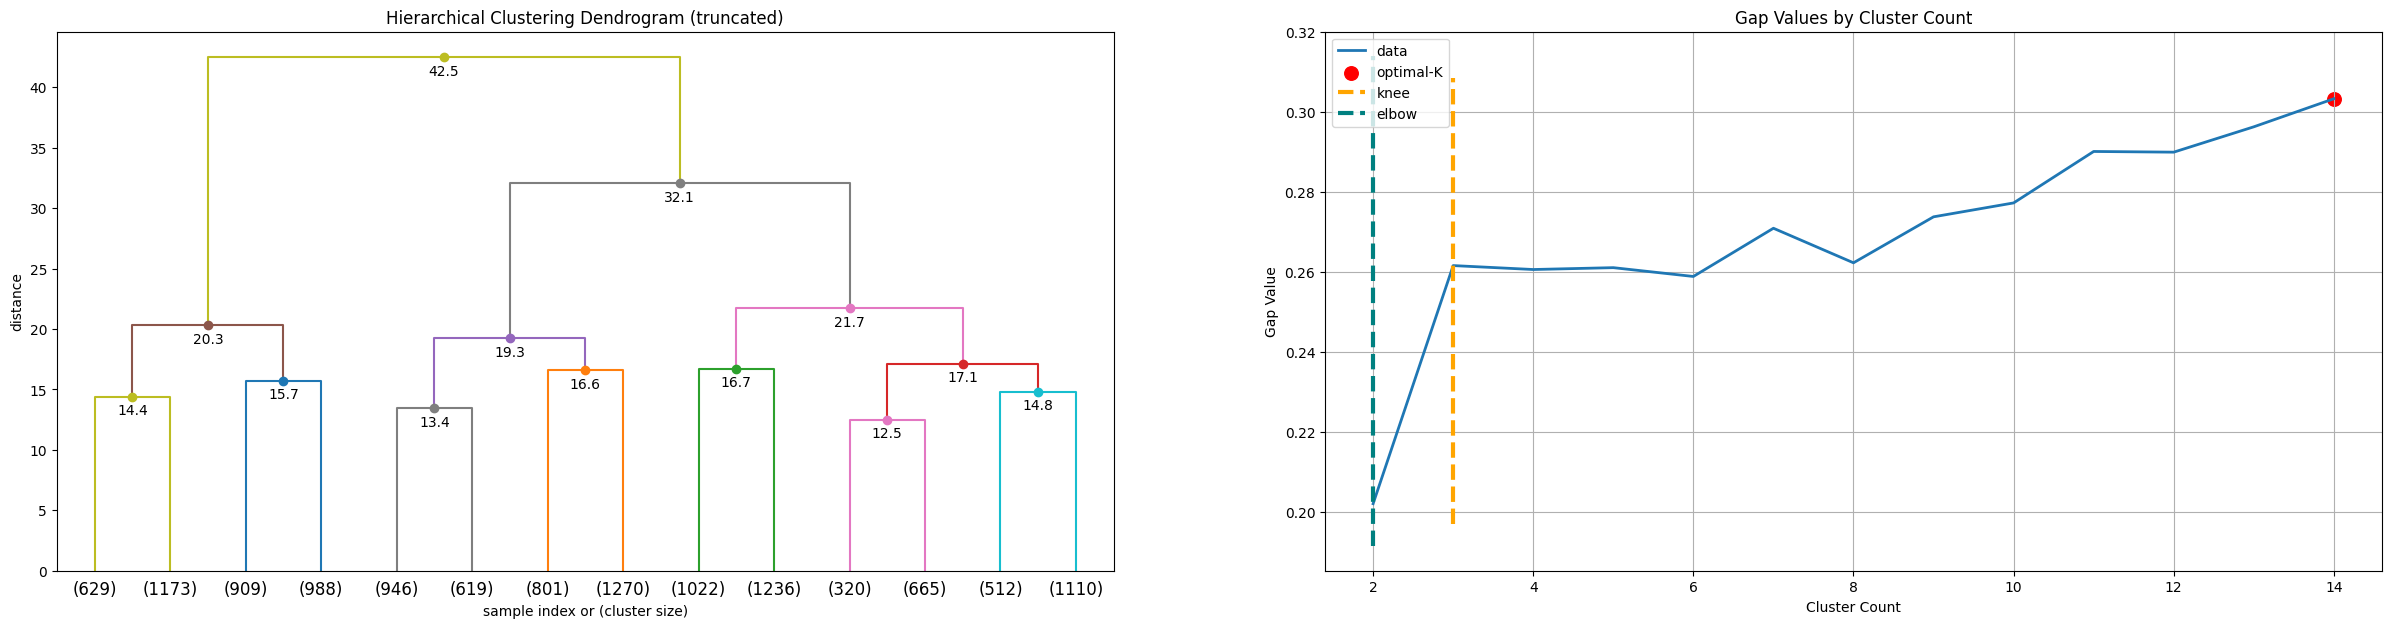

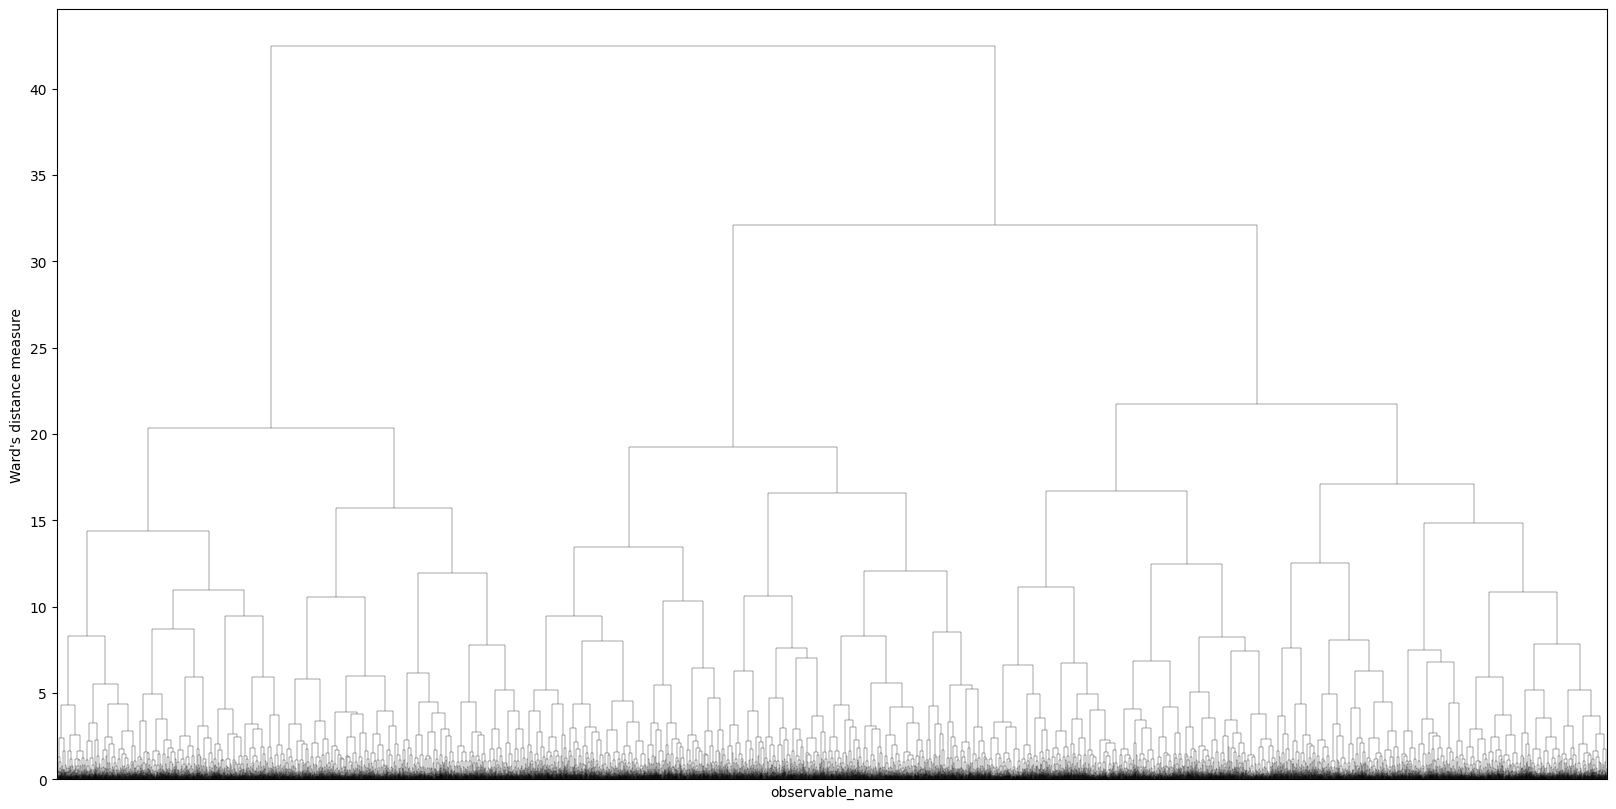

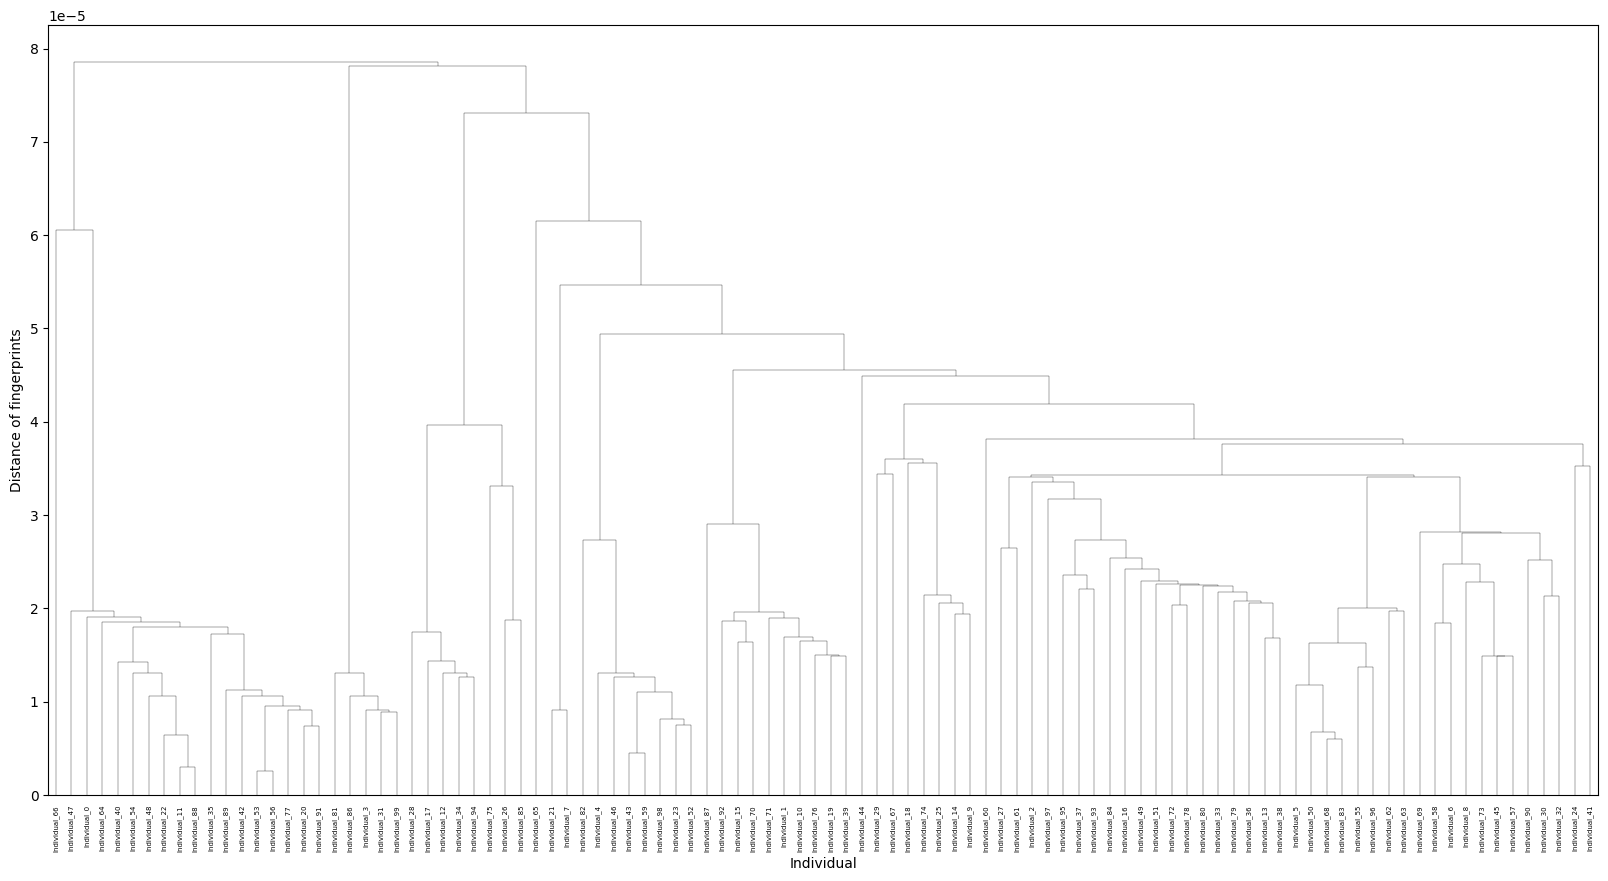

In [14]:
index_name = 'Individual'
my_linkage = 'ward' #'single'

from data_preparation import DataPreparator
from apply_clustering import ClusteringApplier

preparation_result = DataPreparator.prepare_data(
    use_config=False,
    df_observable=df_observable.reset_index(),
    df_explainable=df_explainable.reset_index(),
    distortion_mean=0.,
    distortion_std=0.001,
    observed_features=observed_features,
    explaining_features=explaining_features,
    nn_imputation_k=10,
    group_name=index_name,
)
optimal_number_of_clusters = ClusteringApplier.draw_gap_statistic_plot(
    use_config=False, df_observable=preparation_result['observable_df'],
    observed_features=observed_features,
    gap_statistic_cluster_range=15,
    linkage='ward'
)
observable_patterns_result = ClusteringApplier.calculate_observable_patterns(
    use_config=False,
    df_observable_data=preparation_result['observable_df'],
    _n_clusters=optimal_number_of_clusters['n_clusters'],
    observable_name='observable_name',
    observable_feature_names=observed_features,
    plot_title='Name of the fingerprint plot',
    number_observable_patterns='auto',
    distance_measure_fingerprint='jensenshannon',
    group_name=index_name, 
    spiderplot_scaling='minmax',
    linkage=my_linkage
)

In [15]:
observable_patterns_result['spider_plots']

  0%|          | 0/502 [00:00<?, ?it/s]

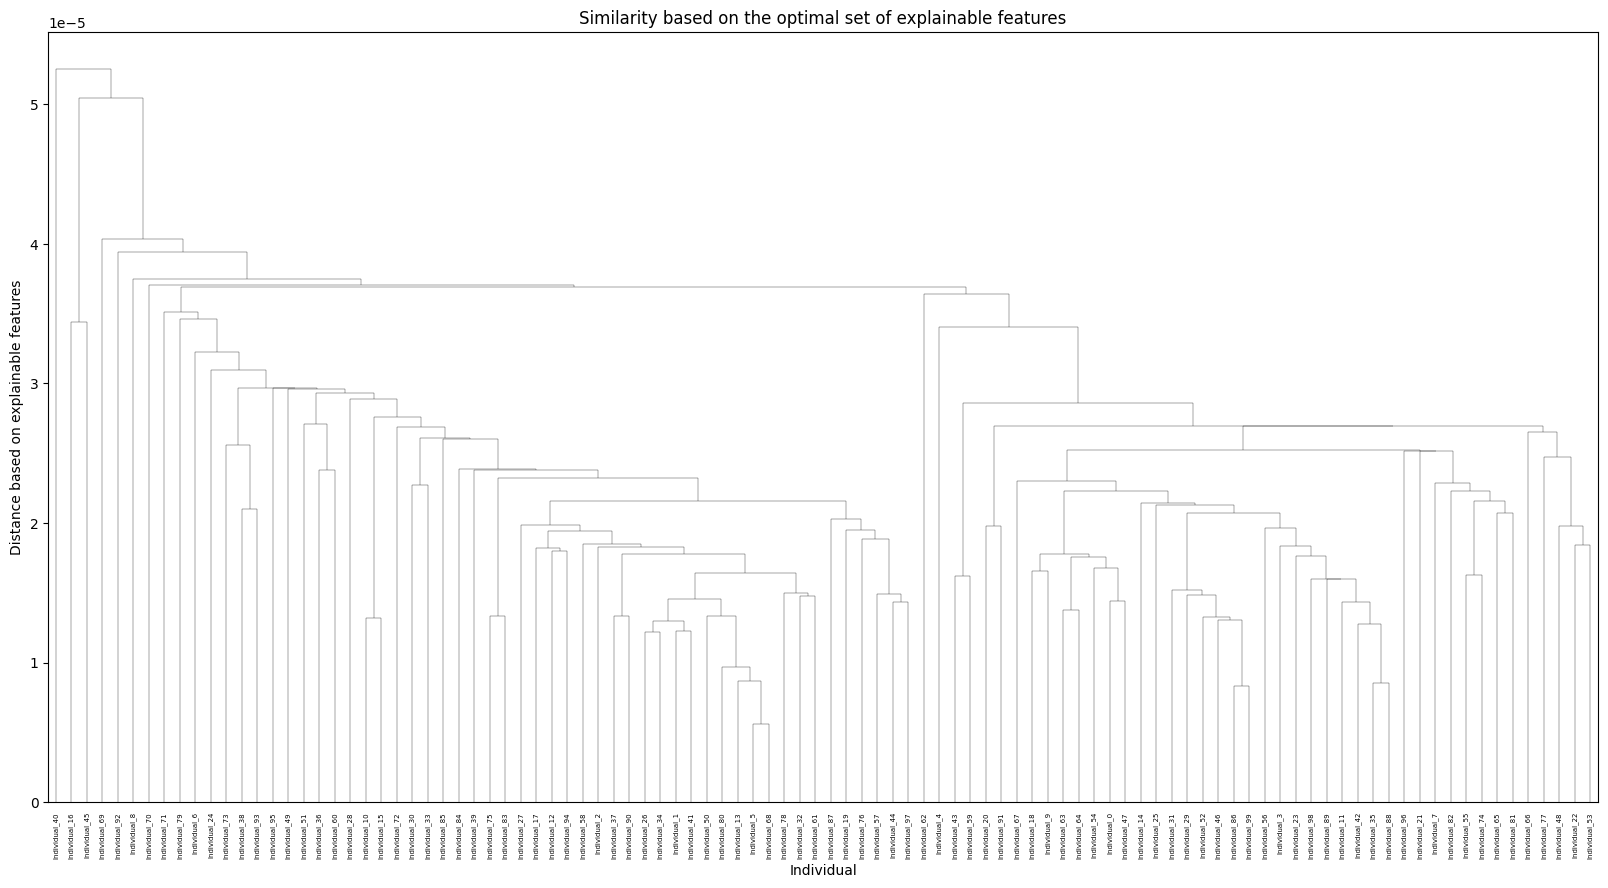

In [16]:
calculate_explainable_distances_result = ClusteringApplier.calculate_explainable_distances(
    use_config=False,
    df_explainable=preparation_result['explainable_df'].copy(),
    df_observable_distances=observable_patterns_result['pw_norm_dist'].copy(),
    explaining_features=explaining_features,
    method='exact',
    distance_measure='correlation',
    sparsity_parameter=0.01,
    max_num_threads=12,
    group_name=index_name
)

In [17]:
calculate_explainable_distances_result['overview_df']

,correlation,Age,Weight,Is_a_Zebra,Loves_to_sleep,Noise_1,Noise_2,Noise_3,Noise_4,Noise_5
0,0.37703,1,0,0,1,0,0,0,0,1


In [18]:
def ward_distance(x, y):
    # Compute the centroids of the two clusters
    centroid_x = torch.mean(x, dim=0)
    centroid_y = torch.mean(y, dim=0)

    # Compute the variance within each cluster
    var_x = torch.sum((x - centroid_x) ** 2) / (x.shape[0] - 1)
    var_y = torch.sum((y - centroid_y) ** 2) / (y.shape[0] - 1)

    # Compute the variance between the two clusters
    var_between = torch.sum((centroid_x - centroid_y) ** 2)

    # Compute the Ward distance
    return var_between + var_x + var_y

In [19]:
keystr = 'df_observable_data'

x = torch.tensor(observable_patterns_result[keystr].loc[:, observed_features].to_numpy())
y = torch.tensor(observable_patterns_result['df_cluster_median'].to_numpy())

alternative = ((x.unsqueeze(1) - y.unsqueeze(0)).pow(2).clamp(min=1e-20)).sum(2).sqrt()

vergleich = observable_patterns_result['df_observable_data'].pattern_type == alternative.argmin(dim=1).numpy() #torch.cdist(x, y).argmin(dim=1).numpy()
print(vergleich)
print(vergleich.sum() / observable_patterns_result[keystr].shape[0])

print(alternative.argmin(dim=1).numpy()[:23])
print(observable_patterns_result['df_observable_data'].pattern_type[:23].to_numpy())

0       False
1        True
2        True
3        True
4       False
        ...  
9995     True
9996     True
9997     True
9998     True
9999    False
Name: pattern_type, Length: 10000, dtype: bool
0.6737
[ 0  7  1 12  1  4  6  2  0  6  4  4  0  3  0  4  7 10 11 10 12  0  8]
[ 1  7  1 12  4  4  6  2  7  6  4  4  0  3  0  4  7 10 11 10  7 13  8]


In [20]:
my_df = observable_patterns_result[keystr].copy()
my_df = my_df[my_df["oversampled"] == False]

In [21]:
my_df.loc[:, [index_name] + observed_features]

,Individual,unexplainable_1,unexplainable_2,unexplainable_3,unexplainable_4,if_zebra_then_age,explained_by_loves_to_sleep,Age_plus_Weight
0,Individual_24,0.906811,0.658156,0.755023,0.446024,0.408604,0.327839,0.562937
1,Individual_79,0.487641,0.362848,0.114911,0.691515,0.826284,0.512344,0.358182
2,Individual_89,0.986186,0.236145,0.769923,0.681268,0.001332,0.343666,0.246934
3,Individual_95,0.299610,0.376260,0.659446,0.591719,0.479411,0.680489,0.352414
4,Individual_36,0.685159,0.393973,0.846925,0.500149,0.026949,0.592482,0.313793
...,...,...,...,...,...,...,...,...
9995,Individual_75,0.034201,0.130378,0.178789,0.432733,0.738998,0.421231,0.834372
9996,Individual_98,0.120471,0.048668,0.927541,0.303808,0.498304,0.103011,0.495450
9997,Individual_69,0.062367,0.948376,0.333125,0.281963,0.582049,0.847271,0.146321
9998,Individual_3,0.797594,0.043427,0.361309,0.355779,1.000855,0.211437,0.637916


In [22]:
df_observable_distances = observable_patterns_result['pw_norm_dist']
df_observable_distances.head()

Individual,Individual_0,Individual_1,Individual_10,Individual_11,Individual_12,Individual_13,Individual_14,Individual_15,Individual_16,Individual_17,...,Individual_90,Individual_91,Individual_92,Individual_93,Individual_94,Individual_95,Individual_96,Individual_97,Individual_98,Individual_99
Individual,,,,,,,,,,,,,,,,,,,,,
Individual_0,0.000000,0.000114,0.000110,0.000042,0.000143,0.000102,0.000119,0.000104,0.000084,0.000141,...,0.000117,0.000029,0.000108,0.000100,0.000141,0.000105,0.000139,0.000094,0.000139,0.000145
Individual_1,0.000114,0.000000,0.000021,0.000118,0.000102,0.000087,0.000104,0.000026,0.000090,0.000093,...,0.000124,0.000120,0.000023,0.000094,0.000097,0.000094,0.000142,0.000077,0.000049,0.000102
Individual_10,0.000110,0.000021,0.000000,0.000116,0.000105,0.000088,0.000106,0.000026,0.000090,0.000095,...,0.000124,0.000117,0.000023,0.000094,0.000099,0.000094,0.000142,0.000078,0.000055,0.000107
Individual_11,0.000042,0.000118,0.000116,0.000000,0.000145,0.000104,0.000115,0.000112,0.000085,0.000145,...,0.000120,0.000041,0.000114,0.000099,0.000145,0.000106,0.000141,0.000099,0.000145,0.000145
Individual_12,0.000143,0.000102,0.000105,0.000145,0.000000,0.000108,0.000118,0.000103,0.000114,0.000024,...,0.000132,0.000145,0.000104,0.000115,0.000013,0.000112,0.000138,0.000105,0.000095,0.000089


In [23]:
fingerprint_df = ClusteringApplier._calculate_fingerprints(
    df = my_df,
    group_name = index_name,
    use_config=False,
)

In [24]:
fingerprint_distanzen, normierte_fingerprint_distanzen = ClusteringApplier.calculate_pairwise_fingerprint_distances(
    df = fingerprint_df,
    distance = 'jensenshannon'
)

In [25]:
@torch.jit.script
def torch_relative_entropy(x:torch.Tensor, y:torch.Tensor) -> torch.Tensor:
    return (x * torch.log(x/y))

In [26]:
@torch.jit.script
def new_torch_matrix_jensenshannon(A:torch.Tensor) -> torch.Tensor:

    ########################################################################################
    ### Conversion of the jensenshannon distance from scipy.spatial.distance to pytorch. ###
    ########################################################################################

    """
    Compute the pairwise Jensen-Shannon distance (metric) between
    all entries in a matrix. This is the square root
    of the Jensen-Shannon divergence.

    The Jensen-Shannon distance between two probability
    vectors `p` and `q` is defined as,

    .. math::

       \\sqrt{\\frac{D(p \\parallel m) + D(q \\parallel m)}{2}}

    where :math:`m` is the pointwise mean of :math:`p` and :math:`q`
    and :math:`D` is the Kullback-Leibler divergence.

    This routine will normalize `p` and `q` if they don't sum to 1.0.

    Parameters
    ----------
    A : (N,M) array_like
        matrix of probability vectors
    
    Returns
    -------
    js : double or ndarray
        The Jensen-Shannon distances along the `axis`.

    """
    
    clamped_A = A.clamp(min = 1e-20)
    normalized_A = clamped_A / torch.sum(clamped_A, dim=1).unsqueeze(-1)
    m_A = (normalized_A.unsqueeze(-1) + normalized_A.T).permute(2,0,1) / 2.0
    relative_entropies = torch_relative_entropy(normalized_A, m_A) + 1e-10
    js = (relative_entropies.sum(dim = 2) + relative_entropies.sum(dim = 2).T).clamp(min = 0.)
    return (js / 2.0).sqrt()

In [ ]:
class FeatureSelectionModel(Paremeterized_Model):
    def __init__(self, df_explainable:pd.DataFrame, df_observable:pd.DataFrame, df_cluster:pd.DataFrame|torch.Tensor, num_virtual_features:int, index_name:str, num_samples:int=1, power:int=4, penalty=0., device='cpu', clip_value=0, dtype=torch.float64):
        super().__init__(device, dtype)

        self.df_explainable = df_explainable.copy()
        self.df_explainable.sort_index(inplace=True)

        self.df_observable = df_observable.copy()
        self.df_observable.sort_values(index_name, inplace=True)
        self.df_observable.reset_index(inplace=True, drop=True)

        self.tensor_explainable = torch.tensor(self.df_explainable.to_numpy(), dtype=self.dtype, device=self.device).clamp(min=1e-20, max=1.)
        self.tensor_observable  = torch.tensor(self.df_observable.set_index(index_name).to_numpy(), dtype=self.dtype, device=self.device).clamp(min=1e-20, max=1.)

        if isinstance(df_cluster, pd.DataFrame):
            self.cluster_positions  = torch.tensor(df_cluster.to_numpy(), dtype=self.dtype, device=self.device).clamp(min=1e-20)
        else:
            self.cluster_positions = df_cluster.to(self.dtype).to(self.device)

        self.unique_groups = sorted(self.df_observable.loc[:, index_name].unique())
        self.number_of_groups = len(self.unique_groups)
        self.number_of_observations = self.df_observable.shape[0]
        self.mask_tensor = torch.zeros((self.number_of_observations, self.number_of_groups), device=self.device, dtype=self.dtype)

        for name, i in zip(self.unique_groups, np.arange(len(self.unique_groups))):
            _masking_list = (list(self.df_observable.query(f'{index_name} == "{name}"').index))
            self.mask_tensor[_masking_list, i] = 1.
            if name == 'Individual_0':
                self.masking_1 = _masking_list

        # Some sanity check
        for name, i in zip(self.unique_groups, np.arange(len(self.unique_groups))):
            lis = (self.mask_tensor.unsqueeze(2) * self.tensor_observable.unsqueeze(1))[:, i, :].nonzero()[:, 0].unique().numpy()
            a = self.df_observable.iloc[lis].loc[:, index_name]
            assert (a == name).all(), f'Failed sanity check for "{name}": {a}'

        self.power = power

        self.feature_names = list(self.df_explainable.columns)
        self.num_features = len(self.feature_names)

        self.observation_names = list(df_observable.set_index(index_name).columns)

        self.penalty = torch.tensor(penalty, device=self.device, dtype=self.dtype)
        self.num_samples = num_samples

        ###
        self.virtual_features = []
        self.num_virtual_features = num_virtual_features
        for v_i in range(self.num_virtual_features):

            epsilon = 1e-4

            z0 = torch.zeros([len(self.feature_names)]) + epsilon
            z1 = torch.zeros([len(self.feature_names)]) + epsilon
            z1[v_i] = 1. - epsilon
            z2 = torch.ones([len(self.feature_names)]) - epsilon
            

            self.add_param(f'antecedens_positions_{v_i}', z0.logit(), lambda x: x.sigmoid())
            self.add_param(f'consequent_positions_{v_i}', z0.logit(), lambda x: x.sigmoid())
            self.add_param(f'antecedens_weights_{v_i}', z1.logit(), lambda x: x.sigmoid())
            self.add_param(f'consequent_weights_{v_i}', z2.logit(), lambda x: x.sigmoid())

            self.virtual_features.append(v_i)
        ###
        
        self._add_sigmoid_param('feature_weights', N=len(self.feature_names) + self.num_virtual_features, value=0.500, noise=0.100)
        self._add_sigmoid_param('observation_weights', N=len(self.observation_names), value=0.500, noise=0.250)

        self.add_param('cluster_positions', self.cluster_positions.logit(), lambda x: x.sigmoid())
        
        self.best_loss = None 
        self.best_feature_weights = None
        self.best_observation_weights = None

        self.feature_names = np.array(self.feature_names)

        self.U = lambda shape: Uniform(0, 1).sample(shape)

        if clip_value > 0:
            for p in self.parameters.parameters():
                print(p)
                p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))

    def logic_string_helper(self, _weights, positions, thresh):
        _features_indices = (_weights > thresh).nonzero()[0]
        if len(_features_indices) > 0:
            _features = self.feature_names[_features_indices]
            _position = positions[_features_indices]
            _string = ''
            i = 0
            for symbol, pos in zip(_features, _position):
                if pos < 0.5:
                    addendum = 'Higher('
                else:
                    addendum = 'Lower('
                if i == len(_features) - 1:
                    _string += f'{addendum}{symbol})'
                else:
                    _string += f'{addendum}{symbol}) ∧ '
                i += 1
        else:
            _string = 'Falsum'
        return _string

    def interpretation(self, v_i, thresh = 0.05):
            antecedens_positions = self.constrained(f'antecedens_positions_{v_i}').clone().detach().numpy()
            consequent_positions = self.constrained(f'consequent_positions_{v_i}').clone().detach().numpy()
            antecedens_weights   =  self.constrained(f'antecedens_weights_{v_i}').clone().detach().numpy()
            consequent_weights   = self.constrained(f'consequent_weights_{v_i}').clone().detach().numpy()

            antecedens_weights = antecedens_weights/antecedens_weights.sum()
            consequent_weights = consequent_weights/consequent_weights.sum()

            antecedens_string = self.logic_string_helper(antecedens_weights, antecedens_positions, thresh)
            consequent_string = self.logic_string_helper(consequent_weights, consequent_positions, thresh)
            interpretation_string = f'{antecedens_string} ⇒ {consequent_string}'

            return interpretation_string
    
    def try_interpretation(self, v_i, thresh):
        if type(v_i) == int:
            return self.interpretation(v_i, thresh)
        else:
            return v_i

    def _add_param_from_mean_std(self, param_name='', N=1, mean=0.5, std=0.05, noise=0.1):
        alpha, beta = mean_std_to_beta_params(mean, std)
        
        noise_1 = torch.rand(N)
        noise_2 = torch.rand(N)

        feature_alpha_init = alpha * torch.ones(N) * (1.-noise) + noise_1 * noise
        feature_beta_init  = beta  * torch.ones(N) * (1.-noise) + noise_2 * noise

        self.add_param(f'{param_name}_alpha', torch.log(feature_alpha_init), lambda x: x.exp())
        self.add_param(f'{param_name}_beta',  torch.log(feature_beta_init),  lambda x: x.exp())

    def _add_sigmoid_param(self, param_name='', N=1, value=None, noise=0.1):

        noise_1 = torch.rand(N)
        noisy_value = value * torch.ones(N) * (1.-noise) + noise_1 * noise
        init_value = torch.logit(noisy_value)

        self.add_param(param_name, init_value, lambda x: x.sigmoid()) # [-1., 1.] --> [0, 2]
        #foo = lambda x: x/(1+x.abs())
        #self.add_param(param_name, init_value, lambda x: (foo(x) + 1.)/2.)

    def get_weights(self) -> dict:
        w = self.best_feature_weights
        feature_dict = {
            feature_name:float(weight) for feature_name, weight in zip(self.feature_names, w)
        }
        v = self.best_observation_weights
        observation_dict = {
            feature_name:float(weight) for feature_name, weight in zip(self.observation_names, v)
        }
        return feature_dict, observation_dict
        
    def save_if_best_loss(self, loss, feature_weights, observation_weights, cluster_positions):
        if self.best_loss is None:
            self.best_loss = loss.clone().detach()
            self.best_feature_weights = feature_weights.clone().detach()
            self.best_observation_weights = 1.00 + 1e-6 - observation_weights.clone().detach()
            self.best_cluster_positions = cluster_positions.clone().detach()
        elif loss < self.best_loss:
            self.best_loss = loss.clone().detach()
            self.best_feature_weights = feature_weights.clone().detach()
            self.best_observation_weights = 1.00 + 1e-6 - observation_weights.clone().detach()
            self.best_cluster_positions = cluster_positions.clone().detach()
    
    def plot(self, thresh=0.05):

        feature_weights = self.constrained('feature_weights').clone().detach().unsqueeze(0).numpy()
        observation_weights = self.constrained('observation_weights').clone().detach().unsqueeze(0).numpy()
        inv_observation_weights = 1.00 + 1e-6 - observation_weights 

        f = {self.feature_names[i]:feature_weights[:, i] for i in range(len(self.feature_names))}
        for v_i in self.virtual_features:
            interpretation = self.interpretation(v_i, thresh=thresh)
            feature_weight = feature_weights[:, v_i + len(self.feature_names)]
            f[interpretation] = feature_weight

        feature_weight_df = pd.DataFrame(f)
        observation_weight_df = pd.DataFrame({self.observation_names[i]:inv_observation_weights[:, i] for i in range(len(self.observation_names))})

        plt.figure(figsize=(10, 5))
        ax1 = sns.barplot(feature_weight_df)
        ax1.axes.xaxis.set_tick_params(rotation=90)
        ax1.set_title('Feature Weights')
        plt.figure(figsize=(10, 5))
        ax2 = sns.barplot(observation_weight_df)
        ax2.axes.xaxis.set_tick_params(rotation=90)
        ax2.set_title('Observation Weights') 

    def sample_fingerprints(self, inv_observation_weights, cluster_positions):
        epsilon = 1e-20
        _dist = ((self.tensor_observable.unsqueeze(1) - cluster_positions.unsqueeze(0)).pow(2).clamp(min=epsilon) * inv_observation_weights).sum(2).sqrt()
        norm_dist = (_dist / _dist.sum(dim=1).unsqueeze(-1))
        masked_norm_dist = (self.mask_tensor.unsqueeze(2) * norm_dist.unsqueeze(1))
        accumulated_norm_dist = masked_norm_dist.sum(dim=0)
        fingerprint_distances = accumulated_norm_dist / accumulated_norm_dist.sum(dim=1).unsqueeze(-1)
        pow_fingerprints = ((fingerprint_distances.clamp(min=epsilon))**-1).pow(self.power) 
        sampled_fingerprints = Dirichlet(pow_fingerprints).rsample([self.num_samples]).mean(dim=0)
        return sampled_fingerprints
    
    def conditional(self, v_i):
        antecedens_positions = self.constrained(f'antecedens_positions_{v_i}')
        consequent_positions = self.constrained(f'consequent_positions_{v_i}')
        antecedens_weights   =  self.constrained(f'antecedens_weights_{v_i}')
        consequent_weights   = self.constrained(f'consequent_weights_{v_i}')

        antecedens = (self.tensor_explainable - antecedens_positions).abs().pow(antecedens_weights).prod(dim=1)
        consequent = (self.tensor_explainable - consequent_positions).abs().pow(consequent_weights).prod(dim=1)

        return antecedens, consequent

    def loss(self, data:torch.Tensor|None=None) -> torch.tensor:

        # feature_weights
        feature_weights = self.constrained('feature_weights')

        # observation_weights
        observation_weights = self.constrained('observation_weights')
        inv_observation_weights = 1.00 + 1e-6 - observation_weights 

        # cluster positions
        cluster_positions = self.constrained('cluster_positions').clamp(min = 1e-10, max=1e10)

        # fingerprints
        sampled_fingerprints = self.sample_fingerprints(inv_observation_weights, cluster_positions)

        # Construct the distance matrix for the fingerprints
        fingerprint_distances = new_torch_matrix_jensenshannon(sampled_fingerprints)

        # Construct the distance matrix for the features
        feature_weights = (feature_weights / feature_weights.sum())
        feature_weights = feature_weights.repeat(self.tensor_explainable.shape[0],1)
        explainables = self.tensor_explainable.clone()
        for v_i in range(self.num_virtual_features):
            antecedens, consequent = self.conditional(v_i)
            feature_weights[:, self.num_features + v_i] *= antecedens
            explainables = torch.hstack((explainables, consequent.unsqueeze(-1)))

        feature_weights = (feature_weights / feature_weights.sum())
        feature_distances = construct_distance_matrix(
            A=explainables, feature_weights=feature_weights, normalize=False
        )

        # Calculate the correlation between the distance matrix and the observable distances
        coef = pearson_corrcoef(feature_distances, fingerprint_distances)

        #k_penalty = (feature_weights.sum() * self.penalty)

        # Loss
        loss = -coef #+ k_penalty

        self.save_if_best_loss(loss, feature_weights, observation_weights, cluster_positions)

        return loss


In [380]:
'''
Haben:
Konjunktion, Negation

De Morgansche Gesetze:
~(a and b) = ~a or ~b
a or b = ~((~a) and (~b))

'''

'\nHaben:\nKonjunktion, Negation\n\nDe Morgansche Gesetze:\n~(a and b) = ~a or ~b\na or b = ~((~a) and (~b))\n\n'

In [32]:
from gradient_solver import _construct_distance_matrix

In [46]:
df_explainable = preparation_result['explainable_df'].copy().set_index(index_name)
df_observable = observable_patterns_result['df_observable_data'].copy().set_index(index_name).loc[:, observed_features].reset_index()

In [47]:
model = FeatureSelectionModel(
    df_explainable,
    df_observable.loc[:, ['Individual', 'if_zebra_then_age', 'unexplainable_1']],
    #df_observable,
    #observable_patterns_result['df_cluster_median'],
    observable_patterns_result['df_cluster_median'].loc[:, ['if_zebra_then_age', 'unexplainable_1']],
    num_virtual_features=1,
    power = 2,
    index_name = 'Individual',
    num_samples = 4,
    dtype = torch.float64,
    device = 'cpu',
    penalty=0
)

# After this many steps, the learning rate is halved
HALFLIFE = 30

'''optimizer = torch.optim.RMSprop(
    params = [
        {'params': model.parameters['feature_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': model.parameters['observation_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': model.parameters['cluster_positions'], 'lr': 0.1, 'momentum': 0.50},
    ],

)'''
optimizer = torch.optim.RMSprop(lr=0.1, momentum=0.50, params=model.parameters.parameters())

lr_halflife = lambda epochs: 0.5**(1/epochs)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_halflife(HALFLIFE)**epoch)
trainer = Trainer(model = model, optimizer = optimizer, scheduler = scheduler, dataloader = range(100))
print(f'Loss before training: {model.loss().clone().detach()}')
trainer.train(epochs = 10, timeout=60000)

Loss before training: -0.20854697116129295
1/10 --- Mean Loss : -0.632786742326209
2/10 --- Mean Loss : -0.8903973260872043
3/10 --- Mean Loss : -0.9844382857842321
4/10 --- Mean Loss : -0.9844536937981154
5/10 --- Mean Loss : -0.9864934682317958
6/10 --- Mean Loss : -0.9577848081706961
7/10 --- Mean Loss : -0.9891447520256214
8/10 --- Mean Loss : -0.9931961498635231
9/10 --- Mean Loss : -0.9933119183127501
10/10 --- Mean Loss : -0.9931665996805149


In [53]:
model.interpretation(0, 0.05)

'Higher(Is_a_Zebra) ∧ Higher(Noise_5) ⇒ Higher(Age)'

In [ ]:
IF(Is_a_Zebra > 0.5) 

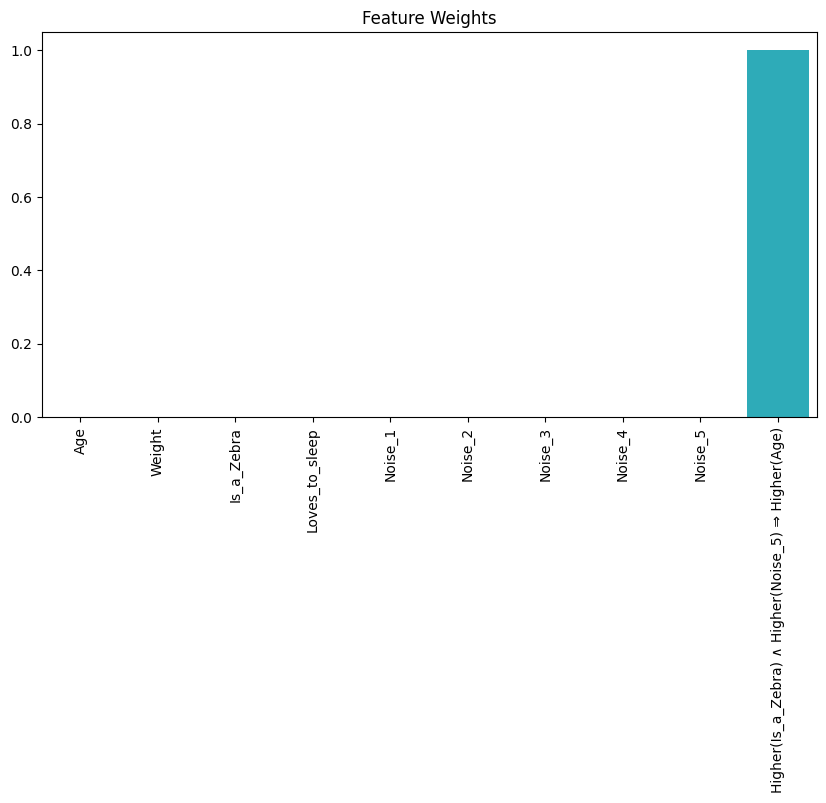

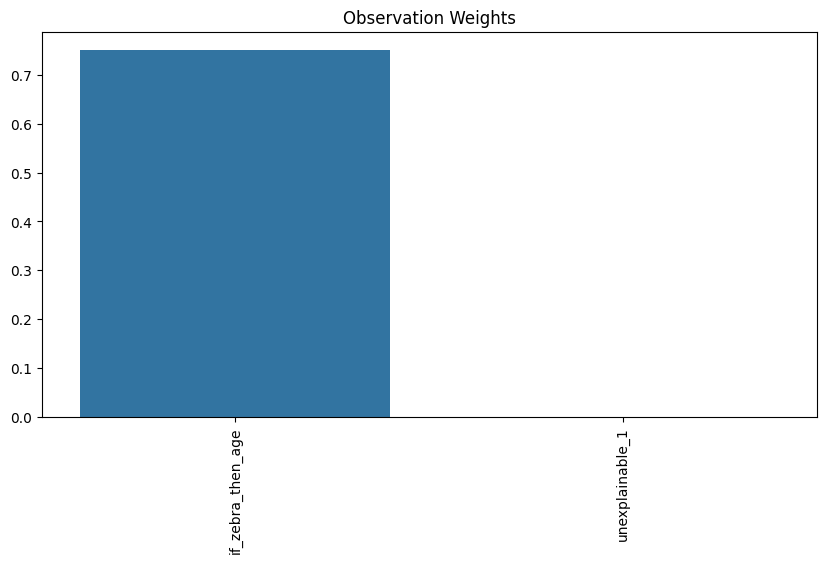

In [54]:
model.plot()

In [188]:
feature_dict, observation_dict = model.get_weights()

remaining_features = []
for k,v in feature_dict.items():
    if True: #v < 0.500:
        remaining_features.append(k)

i = 0
remaining_observations = [index_name]
remaining_observation_indices = []
for k,v in observation_dict.items():
    if v < 0.500:
        remaining_observations.append(k)
        remaining_observation_indices.append(i)
    i += 1

In [189]:
remaining_features, remaining_observations

(['Age',
  'Weight',
  'Is_a_Zebra',
  'Loves_to_sleep',
  'Noise_1',
  'Noise_2',
  'Noise_3',
  'Noise_4',
  'Noise_5',
  'Virtual_Feature_0'],
 ['Individual',
  'unexplainable_1',
  'unexplainable_2',
  'unexplainable_3',
  'unexplainable_4',
  'if_zebra_then_age',
  'Age_plus_Weight'])

In [227]:
next_model = FeatureSelectionModel(
    df_explainable,
    df_observable.loc[:, remaining_observations],
    model.best_cluster_positions[:, remaining_observation_indices],
    num_virtual_features=1,
    power = 4,
    index_name = 'Individual',
    num_samples = 4,
    dtype = torch.float64,
    device = 'cpu',
    penalty=0
)

# After this many steps, the learning rate is halved
HALFLIFE = 50

optimizer = torch.optim.RMSprop(lr=0.1, momentum=0.50, params=next_model.parameters.parameters())

lr_halflife = lambda epochs: 0.5**(1/epochs)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_halflife(HALFLIFE)**epoch)
trainer = Trainer(model = next_model, optimizer = optimizer, scheduler = scheduler, dataloader = range(100))
print(f'Loss before training: {next_model.loss().clone().detach()}')
trainer.train(epochs = 10, timeout=60000)

Loss before training: -0.22132440031087497
1/10 --- Mean Loss : -0.7786275364099853
2/10 --- Mean Loss : -0.8167321350660051
3/10 --- Mean Loss : -0.8337096013460394
4/10 --- Mean Loss : -0.8407994198783739
5/10 --- Mean Loss : -0.8429273909684857
6/10 --- Mean Loss : -0.8444040318485582
7/10 --- Mean Loss : -0.8474241615683251
8/10 --- Mean Loss : -0.8551229162383259
9/10 --- Mean Loss : -0.8992524892342992
10/10 --- Mean Loss : -0.9581734163180101


In [364]:
def logic_string_helper(self, _weights, positions, thresh):
    _features_indices = (_weights > thresh).nonzero()[0]
    if len(_features_indices) > 0:
        _features = self.feature_names[_features_indices]
        _position = positions[_features_indices]
        _string = ''
        i = 0
        for symbol, pos in zip(_features, _position):
            if pos < 0.5:
                addendum = 'Higher('
            else:
                addendum = 'Lower('
            if i == len(_features) - 1:
                _string += f'{addendum}{symbol})'
            else:
                _string += f'{addendum}{symbol}) ∧ '
            i += 1
    else:
        _string = 'Falsum'
    return _string

def interpretation(self, v_i, thresh = 0.05):
        antecedens_positions = self.constrained(f'antecedens_positions_{v_i}').clone().detach().numpy()
        consequent_positions = self.constrained(f'consequent_positions_{v_i}').clone().detach().numpy()
        antecedens_weights   =  self.constrained(f'antecedens_weights_{v_i}').clone().detach().numpy()
        consequent_weights   = self.constrained(f'consequent_weights_{v_i}').clone().detach().numpy()

        antecedens_weights = antecedens_weights/antecedens_weights.sum()
        consequent_weights = consequent_weights/consequent_weights.sum()

        antecedens_string = logic_string_helper(self, antecedens_weights, antecedens_positions, thresh)
        consequent_string = logic_string_helper(self, consequent_weights, consequent_positions, thresh)
        interpretation_string = f'{antecedens_string} ⇒ {consequent_string}'

        return interpretation_string

In [232]:
self = next_model

In [367]:
interpretation(self, 0)

'Higher(Age) ∧ Higher(Weight) ⇒ Lower(Age)'

In [292]:
thresh = 0.05

In [305]:
antecedens_positions = self.constrained(f'antecedens_positions_{v_i}').clone().detach().numpy()
consequent_positions = self.constrained(f'consequent_positions_{v_i}').clone().detach().numpy()
antecedens_weights   =  self.constrained(f'antecedens_weights_{v_i}').clone().detach().numpy()
consequent_weights   = self.constrained(f'consequent_weights_{v_i}').clone().detach().numpy()

In [306]:
antecedens_weights = antecedens_weights/antecedens_weights.sum()
consequent_weights = consequent_weights/consequent_weights.sum()

In [318]:
antecedens_features_indices = (antecedens_weights > thresh).nonzero()[0]
if len(antecedens_features_indices) > 0:
    antecedens_features = self.feature_names[antecedens_features_indices]
    antecedens_position = antecedens_positions[antecedens_features_indices]
    antecedens_string = ''
    i = 0
    for symbol, pos in zip(antecedens_features, antecedens_position):
        if pos < 0.5:
            addendum = 'Higher('
        else:
            addendum = 'Lower('
        if i == len(antecedens_features) - 1:
            antecedens_string += f'{addendum}{symbol})'
        else:
            antecedens_string += f'{addendum}{symbol}) ∧ '
        i += 1
else:
    antecedens_string = 'Falsum'

'Higher(Age) ∧ Higher(Weight) ⇒ Lower(Age)'

In [319]:
consequent_features_indices = (consequent_weights > thresh).nonzero()[0]
if len(consequent_features_indices) > 0:
    consequent_features = self.feature_names[consequent_features_indices]
    consequent_position = consequent_positions[consequent_features_indices]
    consequent_string = ''
    i = 0
    for symbol, pos in zip(consequent_features, consequent_position):
        if pos < 0.5:
            addendum = 'Higher('
        else:
            addendum = 'Lower('
        if i == len(consequent_features) - 1:
            consequent_string += f'{addendum}{symbol})'
        else:
            consequent_string += f'{addendum}{symbol}) ∧ '
        i += 1
else:
    consequent_string = 'Falsum'

In [320]:
f'{antecedens_string} ⇒ {consequent_string}'

'Higher(Age) ∧ Higher(Weight) ⇒ Lower(Age)'

In [298]:
antecedens_string = [antecedens_features]

<Axes: >

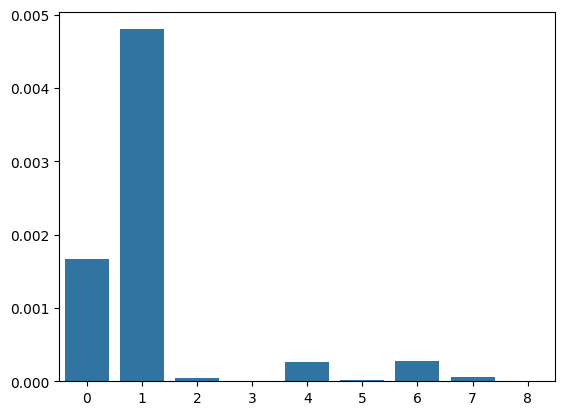

In [321]:
sns.barplot(antecedens_positions)

<Axes: >

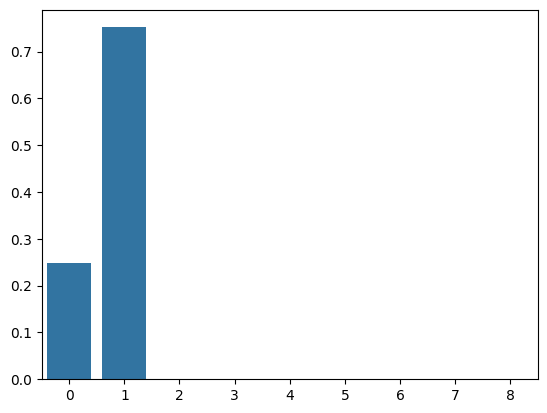

In [299]:
sns.barplot(antecedens_weights)

<Axes: >

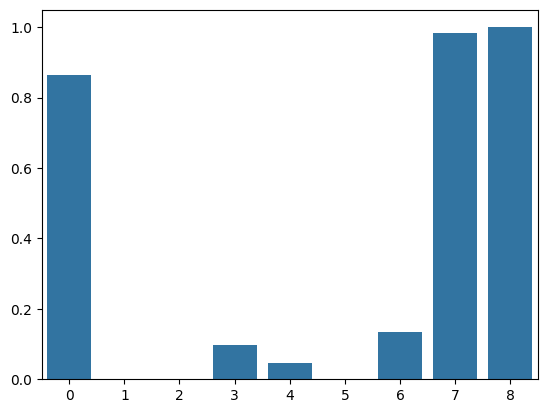

In [322]:
sns.barplot(consequent_positions)

<Axes: >

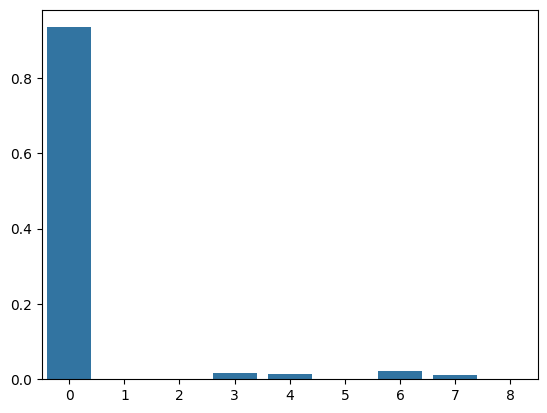

In [300]:
sns.barplot(consequent_weights)

In [229]:
next_model.conditional(0)

tensor([0.3314, 0.3386, 0.1217, 0.1240, 0.1264, 0.1257, 0.1244, 0.3349, 0.1200,
        0.1316, 0.8054, 0.3299, 0.3508, 0.3533, 0.7970, 0.7859, 0.1164, 0.3341,
        0.3135, 0.3190, 0.1251, 0.3170, 0.7688, 0.3360, 0.3530, 0.7950, 0.1239,
        0.8033, 0.1255, 0.7773, 0.7606, 0.3521, 0.3211, 0.8216, 0.1292, 0.1266,
        0.8442, 0.1313, 0.3127, 0.3228, 0.1230, 0.3376, 0.1219, 0.3153, 0.1212,
        0.1229, 0.1303, 0.3442, 0.1158, 0.3305, 0.3416, 0.3241, 0.1249, 0.3116,
        0.3297, 0.7792, 0.8019, 0.1255, 0.3110, 0.3502, 0.7531, 0.1248, 0.1272,
        0.7864, 0.3478, 0.1321, 0.7973, 0.7610, 0.3514, 0.1295, 0.1264, 0.3181,
        0.7739, 0.7898, 0.8269, 0.7448, 0.7647, 0.3492, 0.7193, 0.7708, 0.7506,
        0.3321, 0.8020, 0.8005, 0.8089, 0.3476, 0.3351, 0.7994, 0.7976, 0.1253,
        0.7895, 0.3009, 0.3527, 0.3131, 0.1136, 0.3477, 0.1177, 0.7882, 0.1202,
        0.3444], dtype=torch.float64, grad_fn=<AddBackward0>)

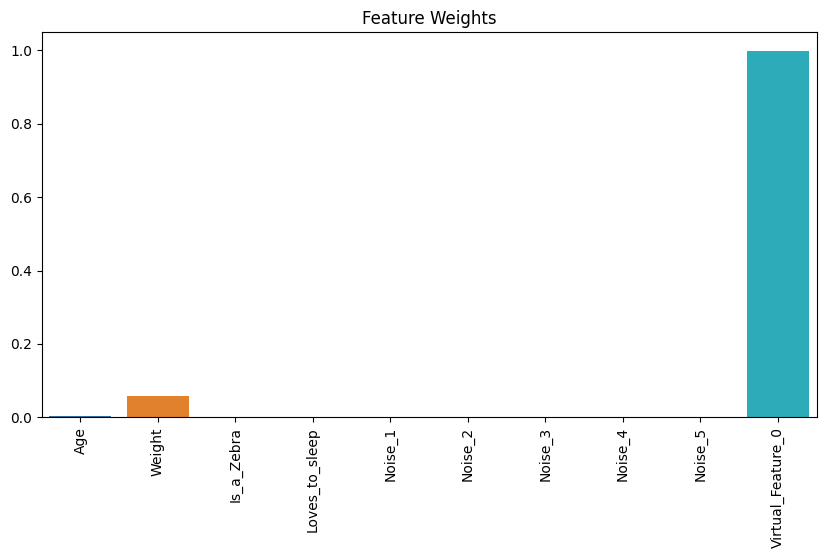

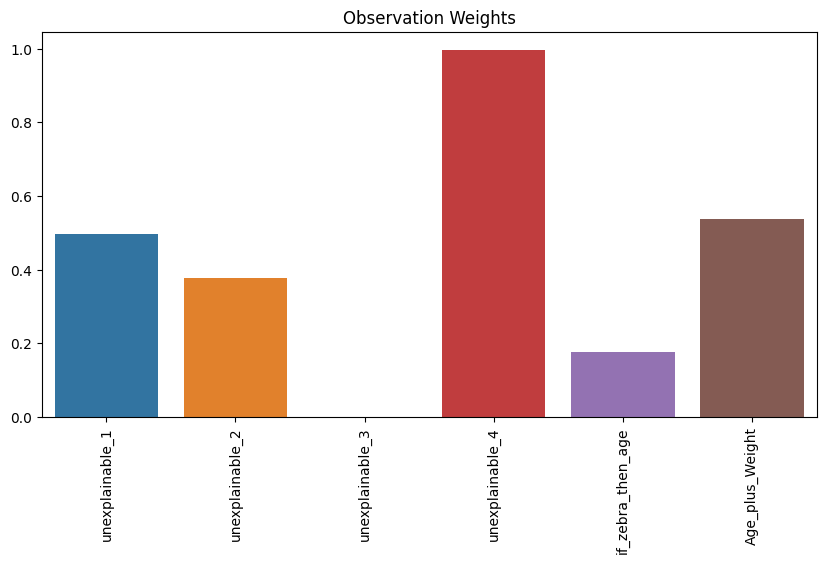

In [230]:
next_model.plot()

In [352]:
feature_dict, observation_dict = next_model.get_weights()

remaining_features = []
for k,v in feature_dict.items():
    #if v < 0.500:
    if True:
        remaining_features.append(k)

i = 0
remaining_observations = [index_name]
remaining_observation_indices = []
for k,v in observation_dict.items():
    if v < 0.500:
        remaining_observations.append(k)
        remaining_observation_indices.append(i)
    i += 1

remaining_features, remaining_observations

([np.str_('Age'),
  np.str_('Weight'),
  np.str_('Is_a_Zebra'),
  np.str_('Loves_to_sleep'),
  np.str_('Noise_1'),
  np.str_('Noise_2'),
  np.str_('Noise_3'),
  np.str_('Noise_4'),
  np.str_('Noise_5'),
  np.str_('Virtual_Feature_0')],
 ['Individual',
  'unexplainable_1',
  'unexplainable_2',
  'unexplainable_3',
  'if_zebra_then_age'])

In [356]:
next2_model = FeatureSelectionModel(
    df_explainable,#.loc[:, remaining_features],
    df_observable.loc[:, remaining_observations],
    model.best_cluster_positions[:, remaining_observation_indices],
    num_virtual_features=1,
    power = 4,
    index_name = 'Individual',
    num_samples = 4,
    dtype = torch.float64,
    device = 'cpu',
    penalty=0
)

my_model = next2_model

# After this many steps, the learning rate is halved
HALFLIFE = 30

optimizer = torch.optim.RMSprop(
    params = [
        {'params': my_model.parameters['feature_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': my_model.parameters['observation_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': my_model.parameters['cluster_positions'], 'lr': 0.1, 'momentum': 0.50},
    ],

)

lr_halflife = lambda epochs: 0.5**(1/epochs)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_halflife(HALFLIFE)**epoch)
trainer = Trainer(model = my_model, optimizer = optimizer, scheduler = scheduler, dataloader = range(100))
print(f'Loss before training: {my_model.loss().clone().detach()}')
trainer.train(epochs = 100, timeout=60000)

Loss before training: -0.1090892073069371
1/100 --- Mean Loss : -0.5975592896614522
2/100 --- Mean Loss : -0.7664176425589853
3/100 --- Mean Loss : -0.7788403117963661
4/100 --- Mean Loss : -0.7833420734613211
5/100 --- Mean Loss : -0.7832376891659737
6/100 --- Mean Loss : -0.7848664044161366
7/100 --- Mean Loss : -0.783408441154676
8/100 --- Mean Loss : -0.7844340693051818
9/100 --- Mean Loss : -0.7844247977343811
10/100 --- Mean Loss : -0.7845412895712753
11/100 --- Mean Loss : -0.7843191084652573
12/100 --- Mean Loss : -0.7856057407115206
13/100 --- Mean Loss : -0.7835103453799879
14/100 --- Mean Loss : -0.7834800619313186
15/100 --- Mean Loss : -0.7837854920513194
16/100 --- Mean Loss : -0.7819477453052598
17/100 --- Mean Loss : -0.7848131839704617
18/100 --- Mean Loss : -0.7827219973471466
19/100 --- Mean Loss : -0.7827651385753343
20/100 --- Mean Loss : -0.7853058384695372
21/100 --- Mean Loss : -0.7834442366774876
22/100 --- Mean Loss : -0.7799575526173148
23/100 --- Mean Loss :

KeyboardInterrupt: 

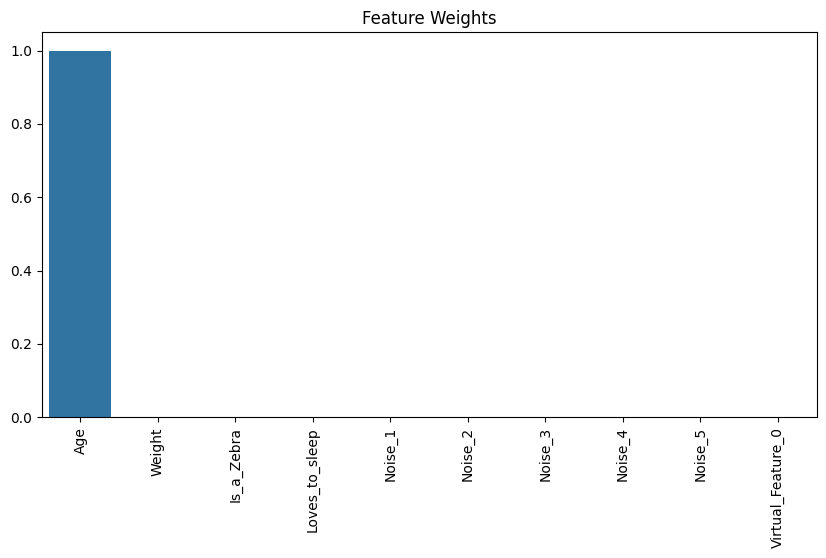

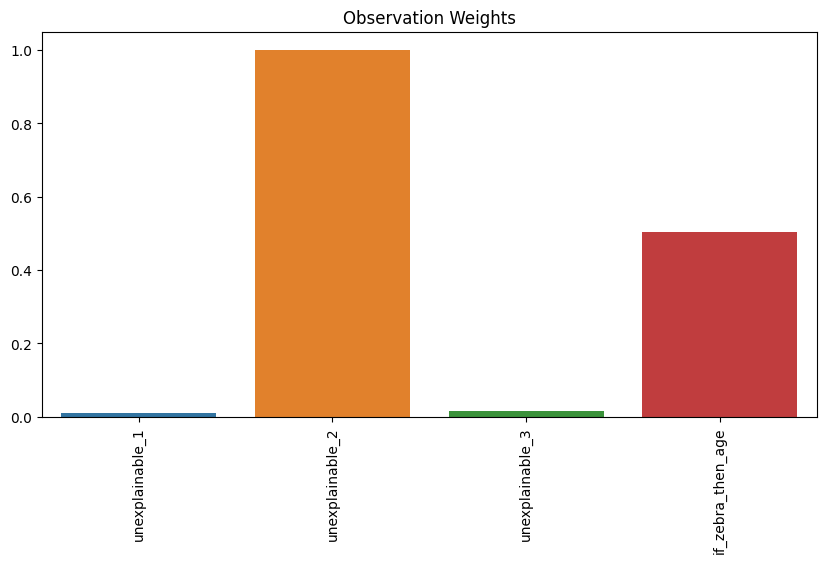

In [357]:
next2_model.plot()

In [40]:
feature_dict, observation_dict = next2_model.get_weights()

remaining_features = []
for k,v in feature_dict.items():
    if v < 0.500:
        remaining_features.append(k)

i = 0
remaining_observations = [index_name]
remaining_observation_indices = []
for k,v in observation_dict.items():
    if v < 0.500:
        remaining_observations.append(k)
        remaining_observation_indices.append(i)
    i += 1

remaining_features, remaining_observations

(['Is_a_Zebra', 'Noise_1', 'Noise_2', 'Noise_3', 'Noise_4', 'Noise_5'],
 ['Individual',
  'unexplainable_1',
  'unexplainable_3',
  'unexplainable_4',
  'Age_plus_Weight'])

In [41]:
next3_model = FeatureSelectionModel(
    df_explainable.loc[:, remaining_features],
    df_observable.loc[:, remaining_observations],
    model.best_cluster_positions[:, remaining_observation_indices],
    power = 4,
    index_name = 'Individual',
    num_samples = 4,
    dtype = torch.float64,
    device = 'cpu',
    penalty=0
)

my_model = next3_model

# After this many steps, the learning rate is halved
HALFLIFE = 30

optimizer = torch.optim.RMSprop(
    params = [
        {'params': my_model.parameters['feature_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': my_model.parameters['observation_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': my_model.parameters['cluster_positions'], 'lr': 0.1, 'momentum': 0.50},
    ],

)

lr_halflife = lambda epochs: 0.5**(1/epochs)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_halflife(HALFLIFE)**epoch)
trainer = Trainer(model = my_model, optimizer = optimizer, scheduler = scheduler, dataloader = range(100))
print(f'Loss before training: {my_model.loss().clone().detach()}')
trainer.train(epochs = 10, timeout=60000)

Loss before training: -0.025800811961319656
1/10 --- Mean Loss : -0.19489734858538463
2/10 --- Mean Loss : -0.3039297338324828
3/10 --- Mean Loss : -0.31474773742549716
4/10 --- Mean Loss : -0.32010635955589734
5/10 --- Mean Loss : -0.32072339910619063
6/10 --- Mean Loss : -0.32084315020486687
7/10 --- Mean Loss : -0.3208739004679591
8/10 --- Mean Loss : -0.3206689445387365
9/10 --- Mean Loss : -0.32218971938639224
10/10 --- Mean Loss : -0.32267942453654425


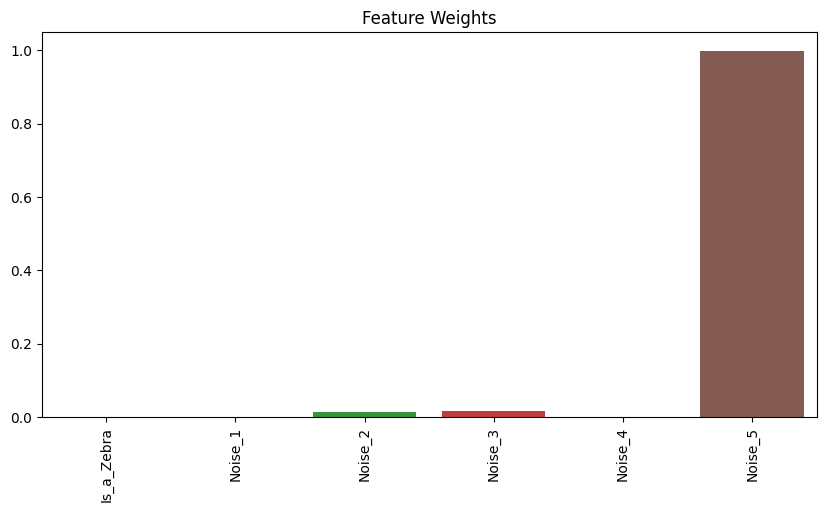

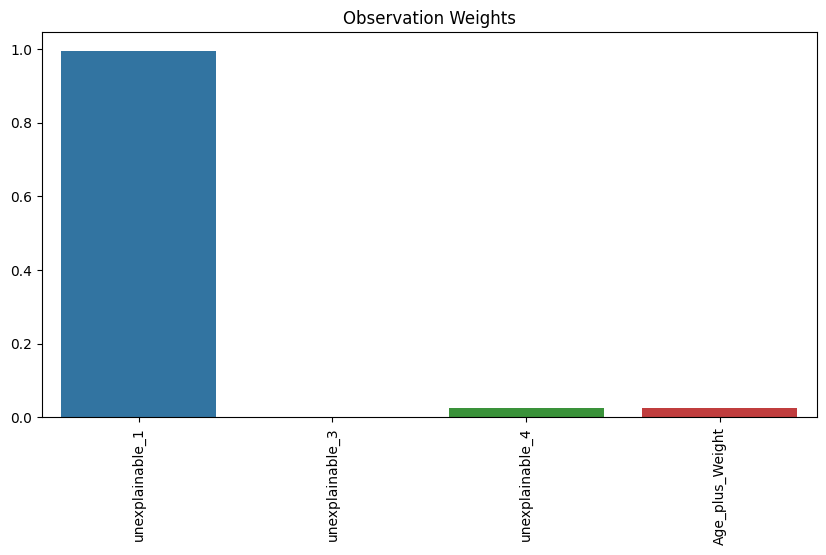

In [42]:
next3_model.plot()

In [43]:
...

Ellipsis